In [3]:
import ps_calculation
import numpy as np
import matplotlib.pyplot as plt
import pyuvdata
import importlib
importlib.reload(ps_calculation)

<module 'ps_calculation' from '/opt/devel/rbyrne/DeltaPS/ps_calculation.py'>

In [3]:
filepath = "/lustre/pipeline/cosmology/41MHz/2026-01-12/12/20260112_120008_41MHz.ms"

In [62]:
ps_2d, kperp_bin_edges, delay_axis, freq_array = ps_calculation.calculate_ps(
    filepath,
)

Setting telescope_location to value in known_telescopes for OVRO-LWA.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 6.7540101049759755 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 6.7540101049759755 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
invalid value encountered in divide


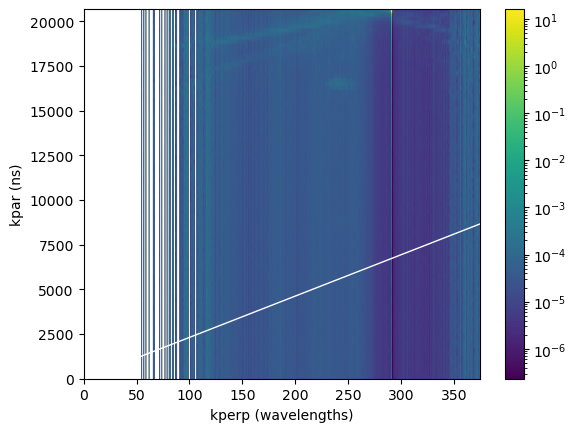

In [63]:
avg_wl = 3e8 / np.mean(freq_array)
plt.imshow(
    ps_2d[:, :, 0].T,
    origin="lower",
    interpolation=None,
    extent=(
        np.min(kperp_bin_edges),
        np.max(kperp_bin_edges),
        0,
        np.max(delay_axis) * 1e9,
    ),
    aspect="auto",
    norm="log",
)
plt.plot(
    kperp_bin_edges,
    kperp_bin_edges * avg_wl / 3e8 * 1e9,
    "-",
    color="white",
    linewidth=1,
)
plt.xlabel("kperp (wavelengths)")
plt.ylabel("kpar (ns)")
plt.colorbar()

In [64]:
uv = pyuvdata.UVData()
uv.read(filepath)
uv.select(polarizations=[-5, -6])
uv.phase_to_time(np.mean(uv.time_array))
uv.conjugate_bls(convention="u>0")
uv.flag_array[np.where(~np.isfinite(uv.data_array))] = True  # Flag all nan-ed data

Setting telescope_location to value in known_telescopes for OVRO-LWA.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 6.7540101049759755 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 6.7540101049759755 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.


In [67]:
freq = uv.freq_array[0]
app_sky = ps_calculation.dft_visibilities(
    uv.data_array[:, 0, 0],
    uv.uvw_array[:, :2] * freq / 3e8,
)

In [68]:
np.shape(app_sky)

(1100, 1100)

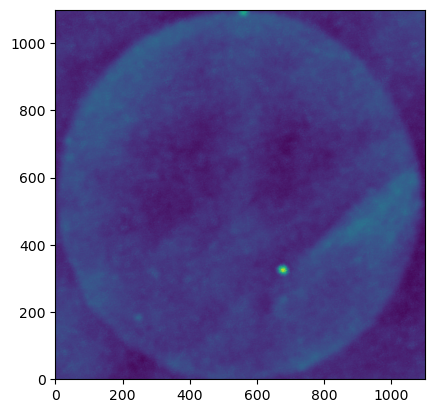

In [69]:
plt.imshow(app_sky.T, origin="lower", interpolation=None)

In [4]:
uv = pyuvdata.UVData()
uv.read(filepath)
uv.select(polarizations=[-5, -6])
uv.phase_to_time(np.mean(uv.time_array))
uv.conjugate_bls(convention="u>0")
uv.flag_array[np.where(~np.isfinite(uv.data_array))] = True  # Flag all nan-ed data
uv.flag_array = np.repeat(
    np.max(uv.flag_array, axis=1)[:, np.newaxis, :], uv.Nfreqs, axis=1
)

visibilities_binned, weights, u_bin_edges, v_bin_edges = ps_calculation.bin_visibilities(
    uv, uv_resolution_wl=0.5
)

Setting telescope_location to value in known_telescopes for OVRO-LWA.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 6.7540101049759755 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 6.7540101049759755 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.


In [63]:
delay_axis = np.fft.fftshift(np.fft.fftfreq(uv.Nfreqs, d=np.mean(uv.channel_width)))
visibilities_ft_1 = ps_calculation.frequency_ft_no_weighting(
    visibilities_binned[1:2, 1:2, :, :1], delay_axis, uv.freq_array[0]
)
visibilities_ft_2 = ps_calculation.frequency_ft_weighting(
    visibilities_binned[1:2, 1:2, :, :1],  # Shape (Nu, Nv, Nfreqs, Npols)
    weights[1:2, 1:2, :, :1],  # Shape (Nu, Nv, Nfreqs, Npols)
    uv.freq_array,  # Shape (Nfreqs)
    delay_axis,
)

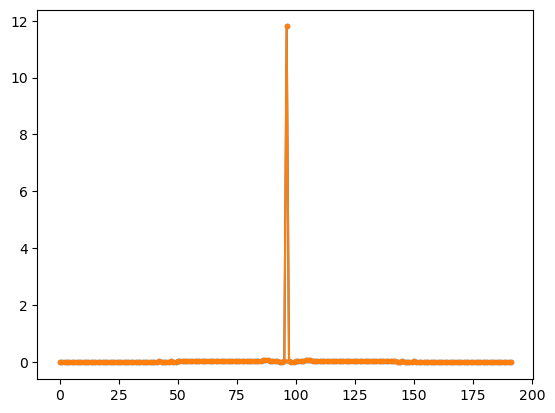

In [64]:
plt.plot(np.real(visibilities_ft_1[0,0,:,0]), ".-")
plt.plot(np.real(visibilities_ft_2[0, 0, :, 0]), ".-")

In [75]:
freq_array = np.arange(40960937.5, 45530761.71875 + 23925.78125, 23925.78125)
delay_axis = np.fft.fftshift(
    np.fft.fftfreq(len(freq_array), d=freq_array[1] - freq_array[0])
)

n_u_points = 3
n_v_points = 4
n_freqs = len(freq_array)
n_pols = 2

# Create a random array of complex visibilities
vis_array = np.random.normal(
    0, 5, size=(n_u_points, n_v_points, n_freqs, n_pols)
) + 1j * np.random.normal(0, 5, size=(n_u_points, n_v_points, n_freqs, n_pols))
weights = np.full_like(
    vis_array, 352, dtype=int
)  # Set all weights to an arbitrary constant

visibilities_ft_1 = ps_calculation.frequency_ft_no_weighting(
    vis_array, delay_axis, freq_array[0]
)
visibilities_ft_2 = ps_calculation.frequency_ft_weighting(
    vis_array,  # Shape (Nu, Nv, Nfreqs, Npols)
    weights,  # Shape (Nu, Nv, Nfreqs, Npols)
    freq_array,  # Shape (Nfreqs)
    delay_axis,
)

In [80]:
np.shape(visibilities_ft_1)

(3, 4, 192, 2)

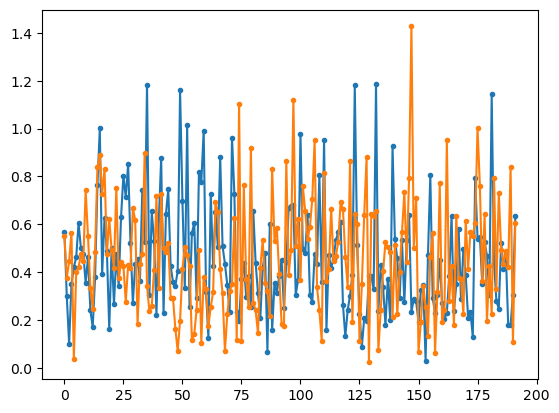

In [83]:
plt.plot(np.abs(visibilities_ft_1[0,0,:,0]), ".-")
plt.plot(np.abs(visibilities_ft_2[0, 0, :, 0]), ".-")

In [76]:
print(visibilities_ft_1)

[[[[-5.56606417e-01-0.11883866j -2.11301193e-01+0.25781488j]
   [ 1.67584295e-01-0.2505409j  -5.41877091e-01+0.17001901j]
   [-1.13192745e-02-0.10032945j  3.34277365e-01-0.08818553j]
   ...
   [ 1.67357712e-01+0.06092473j -3.61367564e-01-0.62797375j]
   [-4.83564379e-03+0.3063265j   2.67990663e-01-0.11220734j]
   [-4.87801759e-01+0.40729056j  7.03947569e-01-0.38135221j]]

  [[ 1.35640031e-01-0.21580888j -3.14485839e-02+0.56541842j]
   [ 4.03097756e-01-0.04635836j  1.15893319e-01+0.02930817j]
   [-3.19261930e-01-0.24700172j -1.71264556e-01+0.25967734j]
   ...
   [-7.08664757e-02+0.382254j    4.34351371e-01-0.04005173j]
   [-1.99665809e-01+0.45718932j -5.67197708e-01+0.16481124j]
   [ 8.72230852e-01-0.38239238j -8.31960194e-02-0.42063327j]]

  [[ 4.06268667e-01-0.94676712j  3.34154730e-02-0.17177627j]
   [ 7.76883073e-03+0.3488407j   6.99077438e-01-0.51802041j]
   [ 2.69950795e-01+0.38748199j  1.59877859e-01-0.12037704j]
   ...
   [-2.76825146e-01-0.34853475j  3.33052236e-01-0.59116213j]

In [79]:
print(visibilities_ft_1 - visibilities_ft_2)

[[[[-0.50272625-0.66535642j  0.42129599+0.70910004j]
   [ 0.10851202-0.61968218j -0.45034917+0.35534625j]
   [ 0.31074363+0.20724874j  0.73550418-0.09832446j]
   ...
   [ 0.04910514+0.89026615j -0.39398817-0.43691517j]
   [-0.02999305+0.41046215j  1.09831786+0.33704183j]
   [-0.18624721+0.93103246j  1.0466222 -0.77388352j]]

  [[ 0.57137333-0.20753003j  0.41272087+0.64836504j]
   [ 0.36098706+0.05175967j -0.16946184-0.22106586j]
   [-0.31633362+0.14242728j  0.2029925 +1.00546572j]
   ...
   [-0.24519284+0.14199593j  0.80351077-0.17808539j]
   [-0.43174754-0.07385505j -0.16514007+0.77438251j]
   [ 0.35057747-0.55494589j  0.00275799-0.02820723j]]

  [[ 0.02000164-1.25531331j  0.49859478-0.5354596j ]
   [ 0.22051014+0.23306964j  0.29600468-0.27691075j]
   [ 0.03331241+0.08517352j  0.21577466-0.2039583j ]
   ...
   [-0.06691994-0.94910949j  0.30306478-0.91889735j]
   [ 1.09821847-0.81127265j -0.05799746-0.28146548j]
   [ 0.2620283 -0.52080709j  0.12385687+0.24371216j]]

  [[ 0.86150453+0.9

In [38]:
measurement_mat = np.nansum(
    weights[1:2, 1:2, :, :1][:, :, :, :, np.newaxis, np.newaxis]
    * np.exp(
        -2
        * np.pi
        * 1j
        * (
            delay_axis[np.newaxis, np.newaxis, np.newaxis, np.newaxis, :, np.newaxis]
            - delay_axis[np.newaxis, np.newaxis, np.newaxis, np.newaxis, np.newaxis, :]
        )
        * uv.freq_array[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis, np.newaxis]
    ),
    axis=2,
)

In [39]:
np.shape(measurement_mat)

(1, 1, 1, 192, 192)

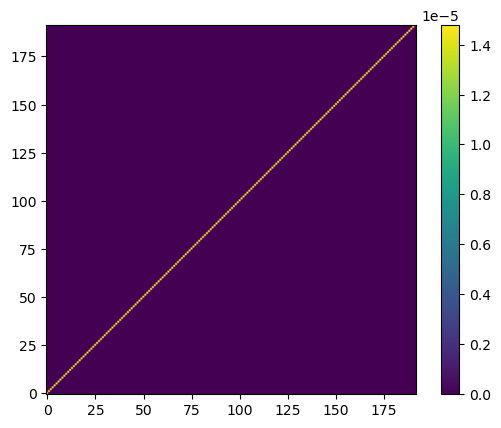

In [43]:
plt.imshow(
    np.abs(np.linalg.inv(measurement_mat[0, 0, 0, :, :])),
    origin="lower",
    interpolation=None,
)
plt.colorbar()

In [80]:
freq_array = np.arange(40960937.5, 45530761.71875 + 23925.78125, 23925.78125)
delay_axis = np.fft.fftshift(
    np.fft.fftfreq(len(freq_array), d=freq_array[1] - freq_array[0])
)
use_vis = visibilities_binned[1, 1, :, 0]
# use_weights = weights[1, 1, :, 0]

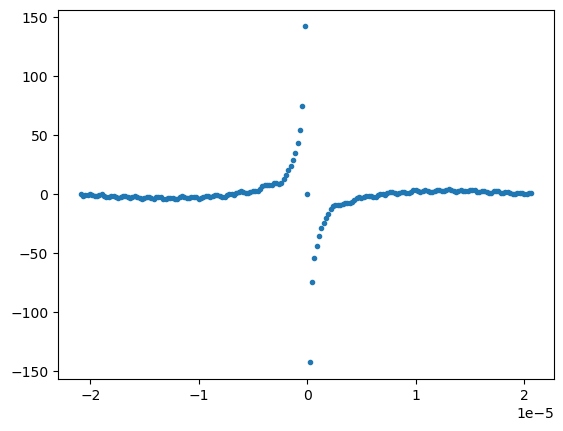

In [85]:
vis_fft_1 = np.fft.fftshift(np.fft.fft(use_vis)) * np.exp(
    -2 * np.pi * 1j * freq_array[0] * delay_axis
)
plt.plot(delay_axis, np.imag(vis_fft_1), ".")

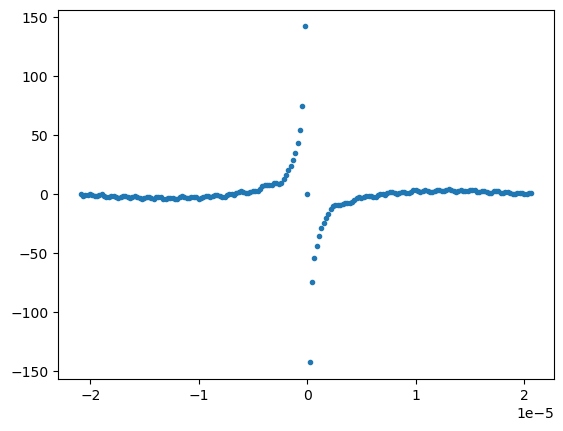

In [86]:
vis_fft_2 = np.sum(
    use_vis[:, np.newaxis]
    * np.exp(-2 * np.pi * 1j * freq_array[:, np.newaxis] * delay_axis[np.newaxis, :]),
    axis=0,
)
plt.plot(delay_axis, np.imag(vis_fft_2), ".")

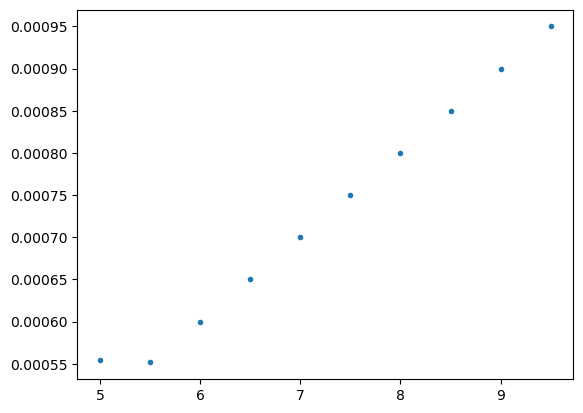

In [61]:
x = np.arange(5, 10, .5)
y = np.exp(-x**2/3) + 1j*x*.0001
plt.plot(x, np.abs(y), ".")

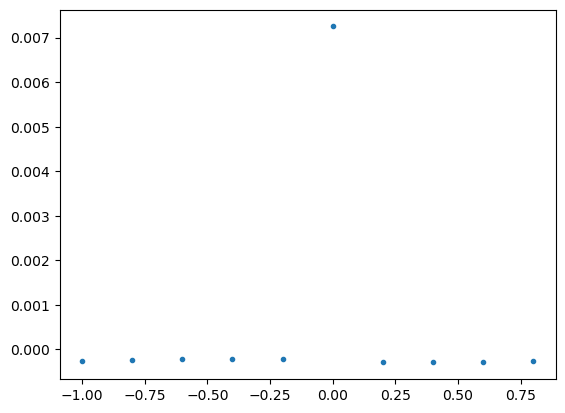

In [62]:
delay_axis = np.fft.fftfreq(len(x), d=x[1]-x[0])
plt.plot(delay_axis, np.imag(np.fft.fft(y)), ".")

In [63]:
y_ft = np.sum(
    y[:, np.newaxis]
    * np.exp(
        -2 * np.pi * 1j * x[:, np.newaxis] * delay_axis[np.newaxis, :]
    ), axis=0
)

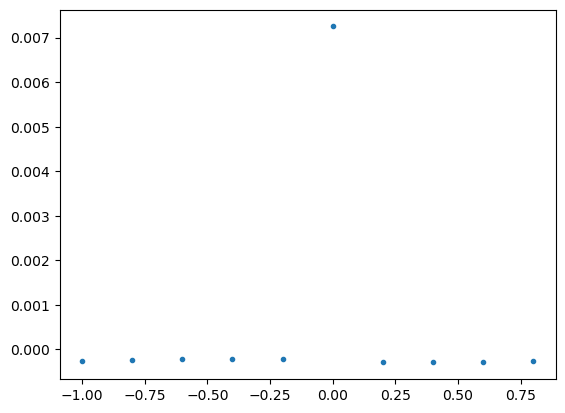

In [64]:
plt.plot(delay_axis, np.imag(y_ft), ".")

In [4]:
Nu = 3
Nv = 4
Npols = 2
Nfreqs = 100

mat_a = np.random.normal(0, 5, size=(Nu, Nv, Npols, Nfreqs, Nfreqs))
mat_b = np.random.normal(0, 5, size=(Nu, Nv, Npols, Nfreqs))
product1 = np.einsum("...ij, ...j -> ...i", mat_a, mat_b)
product2 = np.zeros((Nu, Nv, Npols, Nfreqs), dtype=float)
for u in range(Nu):
    for v in range(Nv):
        for pol in range(Npols):
            product2[u, v, pol, :] = np.matmul(mat_a[u,v,pol,:,:], mat_b[u,v,pol,:])

In [5]:
product1-product2

array([[[[ 1.13686838e-13,  8.52651283e-14, -4.26325641e-14, ...,
          -2.27373675e-13, -2.84217094e-14,  4.26325641e-14],
         [-5.68434189e-14,  2.84217094e-14, -1.42108547e-14, ...,
           1.13686838e-13, -5.68434189e-14, -5.68434189e-14]],

        [[ 1.13686838e-13,  8.52651283e-14,  2.84217094e-14, ...,
          -8.52651283e-14, -4.26325641e-14, -5.68434189e-14],
         [-8.52651283e-14, -2.84217094e-14,  0.00000000e+00, ...,
           7.10542736e-14,  0.00000000e+00, -8.52651283e-14]],

        [[ 4.26325641e-14, -8.52651283e-14,  5.68434189e-14, ...,
           2.84217094e-14,  5.68434189e-14,  0.00000000e+00],
         [ 5.68434189e-14, -2.84217094e-14, -5.68434189e-14, ...,
          -5.68434189e-14,  1.13686838e-13,  1.06581410e-13]],

        [[ 1.13686838e-13,  2.84217094e-14,  2.84217094e-14, ...,
           0.00000000e+00, -2.84217094e-14, -1.13686838e-13],
         [ 7.10542736e-14, -2.84217094e-14,  2.84217094e-14, ...,
           0.00000000e+00,  0.00